In [1]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt

nondef1, nondef2, nondef3, nondef4, nondef5 = sy.symbols('nondef1, nondef2, nondef3, nondef4, nondef5')      

In [2]:
# Präfixe
_nano = 10 ** (-9)
_mikro = 10 ** (-6)
_milli = 10 ** (-3)
_centi = 10 ** (-2)
_dezi = 10 ** (-1)

_Kilo = 10 ** 3
_Mega = 10 ** 6
_Giga = 10 ** 9
_Tera = 10 ** 12

# Winkel
_degree = 2*np.pi/360

In [3]:
# feste Parameter und ihre Zahlenwerte: diese werden später in der Fehlerfunktion numerisch gemacht aber bleiben für die partiellen Ableitungen symbolisch
g, pi, mu_0, G = sy.symbols('g, pi, mu_0, G')            
                                                
fix_parameters = {
    G: 6.672 * 10 ** (-11),
    g: 9.81, 
    pi: 3.141,
    mu_0: 4 * np.pi * 10 **(-7),
}   

In [4]:
# verwendbare, symbolische Variablen, Zusätzliche einfach hinzufügen
t, U0_sy, U90_sy, U0_ref_sy, U90_ref_sy = sy.symbols('t, U0_sy, U90_sy, U0_ref_sy, U90_ref_sy')                     

In [5]:
def err_gauss(f, var1, x1, err1, var2=nondef1, x2=0, err2=0, var3=nondef2, x3=0, err3=0, var4=nondef3, x4=0, err4=0, var5=nondef4, x5=0, err5=0):
    f_x1 = sy.diff(f, var1)
    # print(f'Ableitung nach {var1}: {f_x1}')   
    f_x1 = f_x1.subs({var2: x2, var3: x3, var4: x4, var5: x5})
    f_x2 = sy.diff(f, var2)
    # if f_x2 != 0:
        # print(f'Ableitung nach {var2}: {f_x2}')   
    f_x2 = f_x2.subs({var1: x1, var3: x3, var4: x4, var5: x5})
    f_x3 = sy.diff(f, var3)
    # if f_x3 != 0:
        # print(f'Ableitung nach {var3}: {f_x3}')   
    f_x3 = f_x3.subs({var1: x1, var2: x2, var4: x4, var5: x5})
    f_x4 = sy.diff(f, var4)
    # if f_x4 != 0:
        # print(f'Ableitung nach {var4}: {f_x4}')   
    f_x4 = f_x4.subs({var1: x1, var2: x2, var3: x3, var5: x5})
    f_x5 = sy.diff(f, var5)
    # if f_x5 != 0:
        # print(f'Ableitung nach {var5}: {f_x5}')   
    f_x5 = f_x5.subs({var1: x1, var2: x2, var3: x3, var4: x4})

    # feste paramter numerisch machen
    f = f.subs(fix_parameters)
    f_x1 = f_x1.subs(fix_parameters)
    f_x2 = f_x2.subs(fix_parameters)
    f_x3 = f_x3.subs(fix_parameters)
    f_x4 = f_x4.subs(fix_parameters)
    f_x5 = f_x5.subs(fix_parameters)

    value = f.subs({var1: x1, var2: x2, var3: x3, var4: x4, var5: x5})
    error = (err1**2*(f_x1.subs(var1, x1))**2+err2**2*(f_x2.subs(var2, x2))**2+err3**2*(f_x3.subs(var3, x3))**2+err4**2*(f_x4.subs(var4, x4))**2+err5**2*(f_x5.subs(var5, x5))**2)**0.5
    # print(f'Wert: {value} +/- Fehler: {error}')
    return (value, error)

In [6]:
def gew_mittel(ar_val, ar_err):
    value_num = 0
    sigma_denom = 0
    for i in range(len(ar_val)):
        value_num += ar_val[i]/ar_err[i]**2
        sigma_denom += 1/ar_err[i]**2
    value = value_num/sigma_denom
    sigma = (1/sigma_denom)**0.5
    print(f'gew. Mittelwert: {value} +/- sigma: {sigma}')
    return (value, sigma)

In [7]:
# Import der Messwerte
V23_dataframe = np.loadtxt('./V23.txt', skiprows = 5, delimiter = ',')


# Berechnung Einfallswinkel
angle_reflection = 90 - V23_dataframe[:,0] / 2 
angle_reflection_error = 2.5 / 2


# Berechnung normierte Intensitäten R
U_base = 0.02 + _nano
U0_ref = 3.305 + U_base
U90_ref = 1.029 + U_base

U0 = V23_dataframe[:,1] + U_base
U90 = V23_dataframe[:,2] + U_base
U_error = 0.02*np.sqrt(2)

R0_squared_ec = np.array([err_gauss(
    U0_sy / U0_ref_sy,
    U0_sy, U0[i], U_error,
    U0_ref_sy, U0_ref, U_error,
) for i in range(len(U0))])

R90_squared_ec = np.array([err_gauss(
    U90_sy / U90_ref_sy,
    U90_sy, U90[i], U_error,
    U90_ref_sy, U90_ref, U_error,
) for i in range(len(U90))])


# Quadrierte, normierte Intensitäten mit Fehlern
R0_squared = R0_squared_ec[:,0] 
R0_squared_error = R0_squared_ec[:,1]

R90_squared = R90_squared_ec[:,0] 
R90_squared_error = R90_squared_ec[:,1]


# Normierte Intensitäten
R0 = R0_squared**0.5
R0_error = R0_squared_error / (2*R0_squared**0.5)

R90 = R90_squared**0.5
R90_error = R90_squared_error / (2*R90_squared**0.5)


# manuelles Terminieren der divergierenden Fehler
#R0_error[11:14] = 0
R90_error[9:12] = 0

In [8]:
n_Prisma = 1.63

def f_beta(alpha):
    return np.arcsin(np.sin(alpha) / n_Prisma)


def f_R0_theo(alpha):
    beta = f_beta(alpha)
    return -np.sin(alpha - beta) / np.sin(alpha + beta)


def f_R90_theo(alpha):
    beta = f_beta(alpha)
    return np.tan(alpha - beta) / np.tan(alpha + beta)

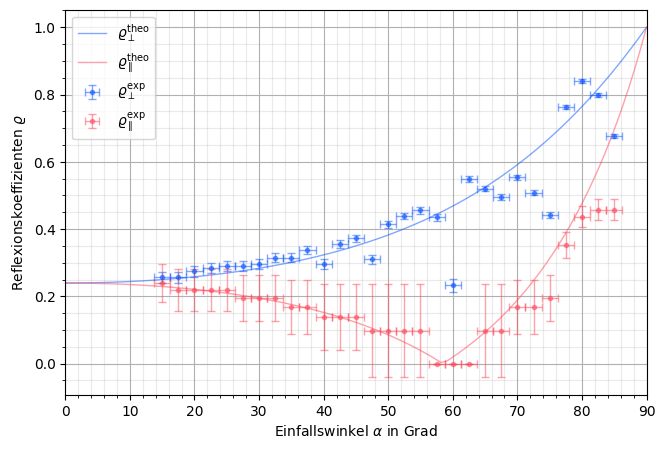

In [96]:
fig, ax = plt.subplots(figsize=(7.5,5))

x_plot_alpha = np.linspace(_nano, 90, 100)
R0_theo = abs(f_R0_theo(x_plot_alpha * _degree))
R90_theo = abs(f_R90_theo(x_plot_alpha * _degree))

#'#FE7018'
#'xkcd:deep sky blue' 
ax.set_xlabel(r'Einfallswinkel $\alpha$ in Grad')
ax.set_ylabel(r'Reflexionskoeffizienten $\varrho$')
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()
ax.plot(x_plot_alpha, R0_theo, color = 'xkcd:electric blue', alpha = 0.5, linewidth = 1, label = r'$\varrho_\perp^\mathrm{theo}$')
ax.plot(x_plot_alpha, R90_theo, color = 'xkcd:watermelon', alpha = 0.5, linewidth = 1, label = r'$\varrho_\parallel^\mathrm{theo}$')
ax.errorbar(angle_reflection, R0, xerr = angle_reflection_error, yerr = R0_error, fmt = '.', color = 'xkcd:electric blue', alpha = 0.5, linewidth = 1, ecolor = 'xkcd:electric blue', capsize = 3, label = r'$\varrho_\perp^\mathrm{exp}$')
ax.errorbar(angle_reflection, R90, xerr = angle_reflection_error, yerr = R90_error, fmt = '.', color = 'xkcd:watermelon', alpha = 0.5, linewidth = 1, ecolor = 'xkcd:watermelon', capsize = 3, label = r'$\varrho_\parallel^\mathrm{exp}$')
ax.legend()
ax.legend(loc="upper left")
plt.xlim([0, 90])
plt.savefig('./V23_Reflexionskoeffizienten.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

In [12]:
# Brechungsindex aus Brewster-Winkel
alpha = sy.symbols('alpha')

alpha_B = 60 * _degree
alpha_B_error = 5  * _degree

n_Flint = err_gauss(
    sy.tan(alpha),
    alpha, alpha_B, alpha_B_error
)

n_Flint

(1.73205080756888, 0.349065850398866)

In [62]:
# Berechnung Drehung Schwingungsebene
angle_analysator = V23_dataframe[:,3] 
drehung_schwingungsebene = (135 - angle_analysator) % 180
drehung_schwingungsebene_error = 5 


# Theoretische Drehung Schwingungsebene
def f_DeltaGamma(alpha):
    arcsin_sin_alpha_divn = np.arcsin(np.sin(alpha/n_Prisma))
    tan_gamma_plus4pi = -np.cos(alpha - arcsin_sin_alpha_divn) / np.cos(alpha + arcsin_sin_alpha_divn)
    return ((np.arctan(tan_gamma_plus4pi) - np.pi / 4) / _degree ) % 180

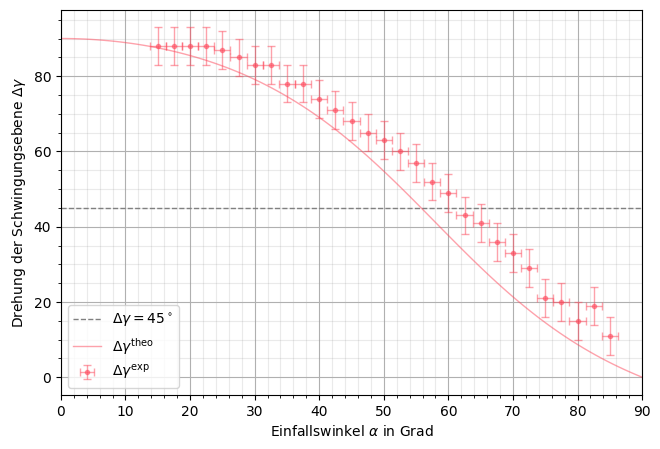

In [111]:
fig, ax = plt.subplots(figsize=(7.5,5))

x_plot_alpha = np.linspace(_nano, 90, 100)
drehung_schwingungsebene_theo = f_DeltaGamma(x_plot_alpha * _degree)
line_45 = [45 for arsch in x_plot_alpha]
 
ax.set_xlabel(r'Einfallswinkel $\alpha$ in Grad')
ax.set_ylabel(r'Drehung der Schwingungsebene $\Delta\gamma$')
ax.grid()
ax.grid(which='minor', color='#999999', alpha=0.2, linestyle='-')
ax.minorticks_on()
ax.plot(x_plot_alpha, line_45, color = 'grey', alpha = 1, linewidth = 1, linestyle = 'dashed', label = r'$\Delta\gamma=45^\circ$')
ax.plot(x_plot_alpha, drehung_schwingungsebene_theo, color = 'xkcd:watermelon', alpha = 0.5, linewidth = 1, label = r'$\Delta\gamma^\mathrm{theo}$')
ax.errorbar(angle_reflection, drehung_schwingungsebene, xerr = angle_reflection_error, yerr = drehung_schwingungsebene_error, 
    fmt = '.', color = 'xkcd:watermelon', alpha = 0.5, linewidth = 1, ecolor = 'xkcd:watermelon', capsize = 3, label = r'$\Delta\gamma^\mathrm{exp}$')
ax.legend()
ax.legend(loc="lower left")
plt.xlim([0, 90])
plt.savefig('./V23_Drehung_Schwingungsebene.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

In [99]:
np.tan(np.pi/2)

1.633123935319537e+16